# Prediction of Credit Risk

## Part 2: Model Selection
### Algorithms Used: <br>
   1.Logistic Regression <br>
   2.Decision Tree <br>
   3.Support Vector Machine  <br>
   4.AdaBoost <br>
   5.Random Forest <br>
   6.Extra Tree Classifier <br>
   7.XGBoost <br>
   8.LightGBM <br>
   9.Multi-Layer Perceptron <br> 

---

### Load the Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

#from ipynb.fs.defs.func import histogram, measures, evaluation_plot
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier , ExtraTreesClassifier

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, ConfusionMatrixDisplay
from yellowbrick.classifier import ROCAUC
from tabulate import tabulate

### Load Preprocessed Dataset

In [13]:
with open('x_train.pickle', 'rb')as file:
    x_train=pickle.load(file)
    
with open('x_test.pickle', 'rb')as file:
    x_test=pickle.load(file)
    
with open('y_train.pickle', 'rb')as file:
    y_train=pickle.load(file)
    
with open('y_test.pickle', 'rb')as file:
    y_test=pickle.load(file)

In [15]:
x_train.shape, x_test.shape

((720, 59), (180, 59))

In [17]:
y_train

335    1
919    1
265    1
1      1
476    0
      ..
923    0
210    0
691    0
610    1
753    0
Name: Class, Length: 720, dtype: int64

### Creating and Saving Cross-Validation Folds in an Excel Workbook

In [27]:
kf = KFold(n_splits=5, random_state=0, shuffle= True)

In [7]:
fold_data = []

for fold, (train_index, val_index) in enumerate(kf.split(x_train), 1):
    x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    fold_data.append((x_train_fold, x_val_fold, y_train_fold, y_val_fold))

# Create an Excel writer object
writer = pd.ExcelWriter('D:/Learn/master/Dissertation/German Statlog/modification/GFold.xlsx', engine='xlsxwriter')

# Save the fold data in separate sheets
for fold, (x_train_fold, x_val_fold, y_train_fold, y_val_fold) in enumerate(fold_data, 1):
    sheet_name = f'Fold {fold}'
    train_data = pd.concat([x_train_fold, y_train_fold], axis=1)
    val_data = pd.concat([x_val_fold, y_val_fold], axis=1)
    fold_data_concat = pd.concat([train_data, val_data], axis=0)
    fold_data_concat.to_excel(writer, sheet_name=sheet_name, index=True)

# Save the Excel file
writer.save()

---
# Hyperparameter Tuning and Classification 
---

In [17]:
def measures(model_name, y_test, y_pred):
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    precision = round(precision_score(y_test, y_pred), 4)
    recall = round(recall_score(y_test, y_pred), 4)
    f1 = round(f1_score(y_test, y_pred), 4)
    cohen_kappa = round(cohen_kappa_score(y_test, y_pred), 4)

    print(f"{model_name} Accuracy: {accuracy}")
    print(f"{model_name} Precision: {precision}")
    print(f"{model_name} Recall: {recall}")
    print(f"{model_name} F1: {f1}")
    print(f"{model_name} Cohen kappa: {cohen_kappa}")

    return [accuracy, precision, recall, f1, cohen_kappa]

In [18]:
def evaluation_plot(model, x_test, y_test, y_pred):
    
    # Confusion Matrix
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.grid(None)

## 1.Logistic Regression

In [14]:
# Create the pipeline
imba_pipeline = make_pipeline(LogisticRegression())
print(f"Cross Validation Score:{cross_val_score(imba_pipeline, x_train, y_train, scoring='accuracy', cv=kf)}")

# Define parameter grid for Logistic Regression
LR_params = {
 'solver': ['saga'],
          'C': [8],
          'max_iter': [5],
          'class_weight': [None],
          'random_state': [0]
}

# Update the parameters to match the name of the Logistic Regression step
new_params = {'logisticregression__' + key: value for key, value in LR_params.items()}

# GridSearchCV with the pipeline and parameters
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='accuracy', return_train_score=True)

# Fit the model
LR = grid_imba.fit(x_train, y_train)

# Print the best score and parameters
print(f"Grid search best score: {round(grid_imba.best_score_, 4)}")
print(f"Grid search best parameters: {grid_imba.best_params_}")


Cross Validation Score:[0.70833333 0.69444444 0.72916667 0.75694444 0.77083333]
Grid search best score: 0.725
Grid search best parameters: {'logisticregression__C': 8, 'logisticregression__class_weight': None, 'logisticregression__max_iter': 5, 'logisticregression__random_state': 0, 'logisticregression__solver': 'saga'}


In [15]:
y_pred_LR = LR.predict(x_test)

In [19]:
LR_measurement = measures('Logistic Regression', y_test, y_pred_LR)

Logistic Regression Accuracy: 0.7278
Logistic Regression Precision: 0.5385
Logistic Regression Recall: 0.5283
Logistic Regression F1: 0.5333
Logistic Regression Cohen kappa: 0.3412


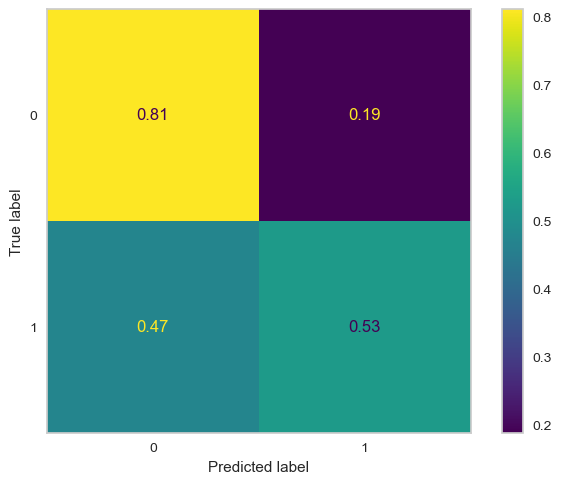

In [22]:
evaluation_plot(LR, x_test, y_test, y_pred_LR)

### 2. Decision Tree

In [12]:
imba_pipeline = make_pipeline(DecisionTreeClassifier())
print(f"Cross Validation Score:{cross_val_score(imba_pipeline, x_train, y_train, scoring ='accuracy',cv=kf)}")

DT_params ={'criterion': ['gini', 'entropy'], 
            'max_depth': [2,4,8,10],
            'min_samples_leaf': [8,10,12,14],
            'random_state': [0]}


new_params = {'decisiontreeclassifier__' + key: DT_params[key] for key in DT_params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf,
                         scoring='accuracy', return_train_score=True)

DT= grid_imba.fit(x_train, y_train)

# print(f"Mean test score: {grid_imba.cv_results_['mean_test_score']}, \nMean train score: {grid_imba.cv_results_['mean_train_score']}")
print(f"Grid search best score: {round(grid_imba.best_score_, 4)}")
print(f"Grid search best parameters: {grid_imba.best_params_}")

Cross Validation Score:[0.68055556 0.70138889 0.63888889 0.63888889 0.72916667]
Grid search best score: 0.6972
Grid search best parameters: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_leaf': 14, 'decisiontreeclassifier__random_state': 0}


In [13]:
y_pred_DT = DT.predict(x_test)

In [14]:
DT_measurement = measures('Decision Tree', y_test, y_pred_DT)

Decision Tree Accuracy: 0.7222
Decision Tree Precision: 0.5962
Decision Tree Recall: 0.5167
Decision Tree F1: 0.5536
Decision Tree Cohen kappa: 0.3534


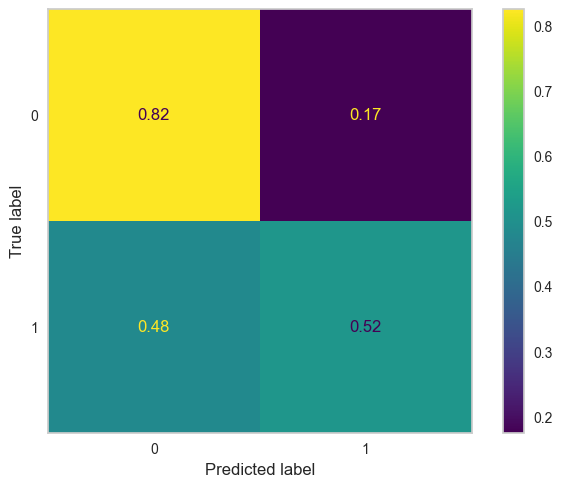

In [15]:
evaluation_plot(DT, x_test, y_test, y_pred_DT)

## 3.SVM

In [16]:
imba_pipeline = make_pipeline(SVC())
print(f"Cross Validation Score:{cross_val_score(imba_pipeline, x_train, y_train, scoring ='accuracy',cv=kf)}")

svc_params = {'C': [2,4,6,8],
              'kernel': ['rbf', 'poly', 'sigmoid','linear'],
              'max_iter': [250,300,350,400],
              'random_state': [0],
              'probability': [True]}

new_params = {'svc__' + key: svc_params[key] for key in svc_params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf,
                         scoring='accuracy', return_train_score=True)

svm= grid_imba.fit(x_train, y_train)

# print(f"Mean test score: {grid_imba.cv_results_['mean_test_score']}, \nMean train score: {grid_imba.cv_results_['mean_train_score']}")
print(f"Grid search best score: {round(grid_imba.best_score_, 4)}")
print(f"Grid search best parameters: {grid_imba.best_params_}")


Cross Validation Score:[0.67361111 0.79861111 0.75       0.70138889 0.77777778]
Grid search best score: 0.7347
Grid search best parameters: {'svc__C': 2, 'svc__kernel': 'rbf', 'svc__max_iter': 400, 'svc__probability': True, 'svc__random_state': 0}


In [17]:
y_pred_SVM = svm.predict(x_test)

In [18]:
SVM_measurement = measures('Support Vector Machine', y_test, y_pred_SVM)

Support Vector Machine Accuracy: 0.7667
Support Vector Machine Precision: 0.6731
Support Vector Machine Recall: 0.5833
Support Vector Machine F1: 0.625
Support Vector Machine Cohen kappa: 0.4569


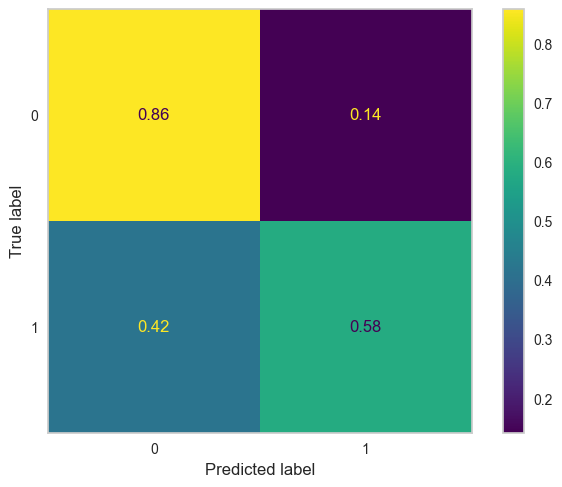

In [19]:
evaluation_plot(svm, x_test, y_test, y_pred_SVM)

## 4. AdaBoost

In [20]:
imba_pipeline = make_pipeline(AdaBoostClassifier())
print(f"Cross Validation Score:{cross_val_score(imba_pipeline, x_train, y_train, scoring ='accuracy',cv=kf)}")

AB_params = {'n_estimators': [ 200,250,300,350], 
             'learning_rate': [0.1,0.2,0.3,0.4,0.5],
             'random_state': [0]}

new_params = {'adaboostclassifier__' + key: AB_params[key] for key in AB_params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf,
                         scoring='accuracy', return_train_score=True)

AB= grid_imba.fit(x_train, y_train)

# print(f"Mean test score: {grid_imba.cv_results_['mean_test_score']}, \nMean train score: {grid_imba.cv_results_['mean_train_score']}")
print(f"Grid search best score: {round(grid_imba.best_score_, 4)}")
print(f"Grid search best parameters: {grid_imba.best_params_}")

Cross Validation Score:[0.73611111 0.69444444 0.74305556 0.66666667 0.79166667]
Grid search best score: 0.7417
Grid search best parameters: {'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 300, 'adaboostclassifier__random_state': 0}


In [50]:
with open('German_AB.pkl' , 'wb') as file:
  pickle.dump(AB, file)

In [22]:
y_pred_AB = AB.predict(x_test)

In [23]:
AB_measurement = measures('AdaBoost', y_test, y_pred_AB)

AdaBoost Accuracy: 0.7722
AdaBoost Precision: 0.6667
AdaBoost Recall: 0.6333
AdaBoost F1: 0.6496
AdaBoost Cohen kappa: 0.481


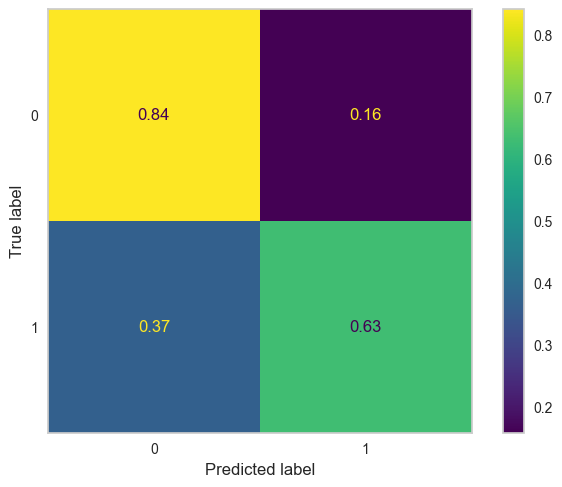

In [24]:
evaluation_plot(AB, x_test, y_test, y_pred_AB)

## 5. Random Forest

In [9]:
imba_pipeline = make_pipeline(RandomForestClassifier())
print(f"Cross validation score: {cross_val_score(imba_pipeline, x_train, y_train, scoring='accuracy', cv=kf)}")

# Grid search
params = {
    'n_estimators': [40,50,60,65],
    'max_depth': [5,10,15,20],
    'min_samples_split': [8,10,12],
    'min_samples_leaf': [1, 2, 3, 4],
    'random_state': [0]
}

new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='accuracy', return_train_score=True)

RF = grid_imba.fit(x_train, y_train)

# print(f"Mean test score: {grid_imba.cv_results_['mean_test_score']}, \nMean train score: {grid_imba.cv_results_['mean_train_score']}")
print(f"Grid search best score: {round(grid_imba.best_score_, 4)}")
print(f"Grid search best parameters: {grid_imba.best_params_}")

Cross validation score: [0.70833333 0.70833333 0.75694444 0.6875     0.77777778]
Grid search best score: 0.7528
Grid search best parameters: {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__n_estimators': 65, 'randomforestclassifier__random_state': 0}


In [10]:
with open('German_RF.pkl' , 'wb') as file:
  pickle.dump(RF, file)

In [11]:
y_pred_RF = RF.predict(x_test)

In [12]:
RF_measurement = measures('Random Forest', y_test, y_pred_RF)

Random Forest Accuracy: 0.8
Random Forest Precision: 0.7857
Random Forest Recall: 0.55
Random Forest F1: 0.6471
Random Forest Cohen kappa: 0.5135


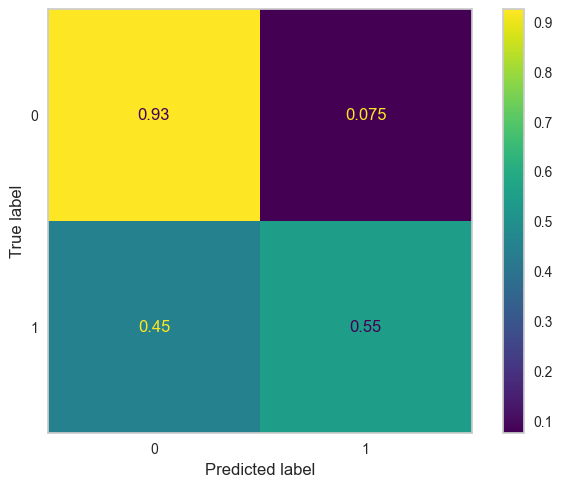

In [13]:
evaluation_plot(RF, x_test, y_test, y_pred_RF)

## 6. Extra Tree Classifier

In [30]:
imba_pipeline = make_pipeline(ExtraTreesClassifier())
print(f"Cross Validation Score:{cross_val_score(imba_pipeline, x_train, y_train, scoring ='accuracy',cv=kf)}")
 
ET_params = {'n_estimators': [25,30,35,40,45],
             'max_depth': [10,15,20,25],
             'criterion': ['gini', 'entropy'],
             'min_samples_split': [16,18,20,25,30],
             'min_samples_leaf': [2,4,6],
             'random_state': [0]}

new_params = {'extratreesclassifier__' + key: ET_params[key] for key in ET_params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf,
                         scoring='accuracy', return_train_score=True)

ET= grid_imba.fit(x_train, y_train)

# print(f"Mean test score: {grid_imba.cv_results_['mean_test_score']}, \nMean train score: {grid_imba.cv_results_['mean_train_score']}")
print(f"Grid search best score: {round(grid_imba.best_score_, 4)}")
print(f"Grid search best parameters: {grid_imba.best_params_}")


Cross Validation Score:[0.69444444 0.72222222 0.76388889 0.6875     0.77083333]
Grid search best score: 0.7403
Grid search best parameters: {'extratreesclassifier__criterion': 'entropy', 'extratreesclassifier__max_depth': 15, 'extratreesclassifier__min_samples_leaf': 2, 'extratreesclassifier__min_samples_split': 25, 'extratreesclassifier__n_estimators': 25, 'extratreesclassifier__random_state': 0}


In [32]:
y_pred_ET = ET.predict(x_test)

In [33]:
ET_measurement = measures('Extra Tree Classifier', y_test, y_pred_ET)

Extra Tree Classifier Accuracy: 0.7889
Extra Tree Classifier Precision: 0.7619
Extra Tree Classifier Recall: 0.5333
Extra Tree Classifier F1: 0.6275
Extra Tree Classifier Cohen kappa: 0.4865


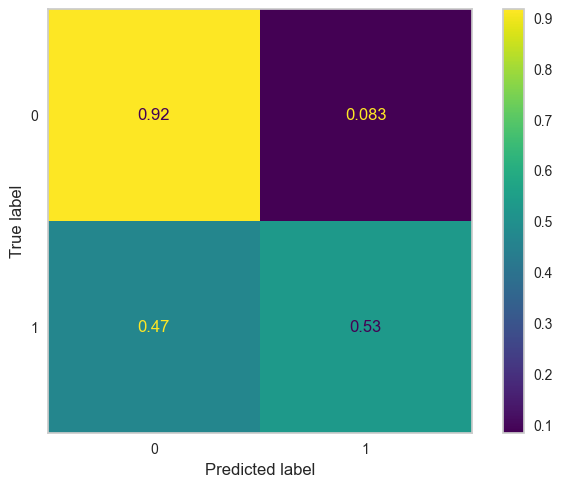

In [34]:
evaluation_plot(ET, x_test, y_test, y_pred_ET)

## 7. XGBoost

In [35]:
imba_pipeline = make_pipeline(XGBClassifier())
print(f"Cross Validation Score:{cross_val_score(imba_pipeline, x_train, y_train, scoring ='accuracy',cv=kf)}")

XGB_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.1,0.2,0.3,0.4,0.5],
        'subsample': [0.6,1,1.5],
        'colsample_bytree': [0.4,0.5,1,1.5],
        'max_depth': [5,10,15,20],
        'eval_metric': ['mlogloss']}

new_params = {'xgbclassifier__' + key: XGB_params[key] for key in XGB_params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf,
                         scoring='accuracy', return_train_score=True)

XGB= grid_imba.fit(x_train, y_train)

# print(f"Mean test score: {grid_imba.cv_results_['mean_test_score']}, \nMean train score: {grid_imba.cv_results_['mean_train_score']}")
print(f"Grid search best score: {round(grid_imba.best_score_, 4)}")
print(f"Grid search best parameters: {grid_imba.best_params_}")

[11:52:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:52:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:52:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:52:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [36]:
y_pred_XGB = XGB.predict(x_test)

In [37]:
XGB_measurement = measures('XGBoost', y_test, y_pred_XGB)

XGBoost Accuracy: 0.75
XGBoost Precision: 0.6531
XGBoost Recall: 0.5333
XGBoost F1: 0.5872
XGBoost Cohen kappa: 0.4105


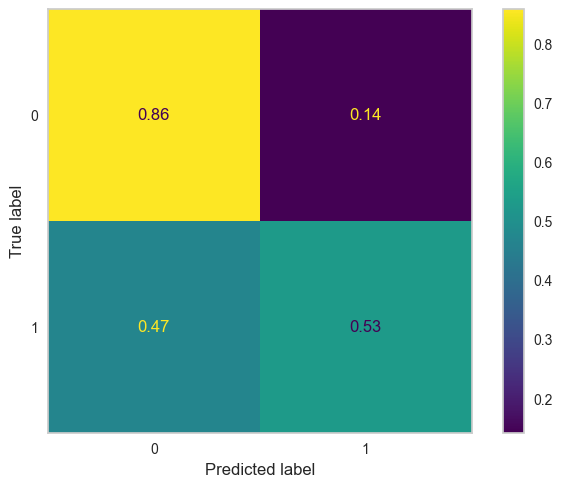

In [38]:
evaluation_plot(XGB, x_test, y_test, y_pred_XGB)

## 8. LightGBM

In [39]:
imba_pipeline = make_pipeline(LGBMClassifier())
print(f"Cross Validation Score:{cross_val_score(imba_pipeline, x_train, y_train, scoring ='accuracy',cv=kf)}")

LGBM_params = {'learning_rate': [0.1,0.2,0.3,0.4,0.5],
                'max_depth': [5,8,10,12,15,20,25],
                'num_leaves': [10,15,20,25],
                'n_estimators': [35,40,60,80],
                'subsample': [0.2,0.4,0.6,0.8,1.0]}

new_params = {'lgbmclassifier__' + key: LGBM_params[key] for key in LGBM_params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf,
                         scoring='accuracy', return_train_score=True)

LGBM= grid_imba.fit(x_train, y_train)

# print(f"Mean test score: {grid_imba.cv_results_['mean_test_score']}, \nMean train score: {grid_imba.cv_results_['mean_train_score']}")
print(f"Grid search best score: {round(grid_imba.best_score_, 4)}")
print(f"Grid search best parameters: {grid_imba.best_params_}")


Cross Validation Score:[0.72916667 0.72916667 0.76388889 0.6875     0.80555556]
Grid search best score: 0.7514
Grid search best parameters: {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 15, 'lgbmclassifier__n_estimators': 35, 'lgbmclassifier__num_leaves': 25, 'lgbmclassifier__subsample': 0.2}


In [40]:
y_pred_LGBM = LGBM.predict(x_test)

In [41]:
LGBM_measurement = measures('LightGBM', y_test, y_pred_LGBM)

LightGBM Accuracy: 0.7722
LightGBM Precision: 0.6667
LightGBM Recall: 0.6333
LightGBM F1: 0.6496
LightGBM Cohen kappa: 0.481


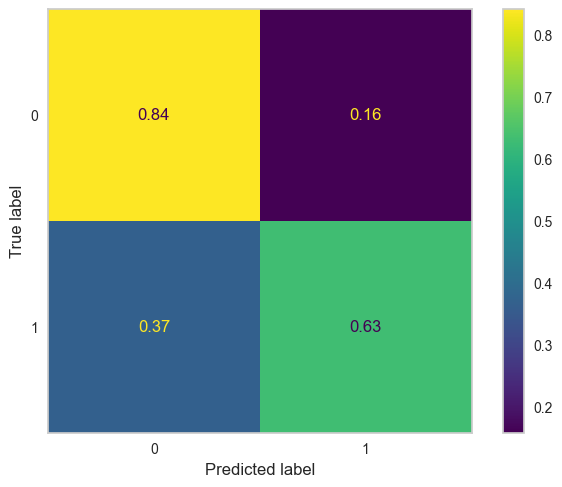

In [42]:
evaluation_plot(LGBM, x_test, y_test, y_pred_LGBM)

## 9. MLP

In [43]:
imba_pipeline = make_pipeline(MLPClassifier())
print(f"Cross Validation Score:{cross_val_score(imba_pipeline, x_train, y_train, scoring ='accuracy',cv=kf)}")

MLP_params = {'hidden_layer_sizes': [(3, 5 , 1), (1, 3, 5), (1,5,3) ,(2,4,6), (10, 5), (10,),(5,10),(5,)],
              'activation': ['logistic', 'relu', 'tanh'],
              'max_iter':[10,20,30,40,50,60,70,80,90,100],
              'solver': ['sgd','adam', 'lbfgs'],
              'random_state': [0],
              'early_stopping': [True]}
new_params = {'mlpclassifier__' + key: MLP_params[key] for key in MLP_params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf,
                         scoring='accuracy', return_train_score=True)

MLP= grid_imba.fit(x_train, y_train)

# print(f"Mean test score: {grid_imba.cv_results_['mean_test_score']}, \nMean train score: {grid_imba.cv_results_['mean_train_score']}")
print(f"Grid search best score: {round(grid_imba.best_score_, 4)}")
print(f"Grid search best parameters: {grid_imba.best_params_}")

Cross Validation Score:[0.65972222 0.69444444 0.6875     0.69444444 0.81944444]
Grid search best score: 0.7375
Grid search best parameters: {'mlpclassifier__activation': 'relu', 'mlpclassifier__early_stopping': True, 'mlpclassifier__hidden_layer_sizes': (5, 10), 'mlpclassifier__max_iter': 20, 'mlpclassifier__random_state': 0, 'mlpclassifier__solver': 'lbfgs'}


In [52]:
with open('German_MLP.pkl' , 'wb') as file:
  pickle.dump(MLP, file)

In [44]:
y_pred_MLP = MLP.predict(x_test)

In [45]:
MLP_measurement = measures('MLP', y_test, y_pred_MLP)

MLP Accuracy: 0.7889
MLP Precision: 0.6719
MLP Recall: 0.7167
MLP F1: 0.6935
MLP Cohen kappa: 0.5328


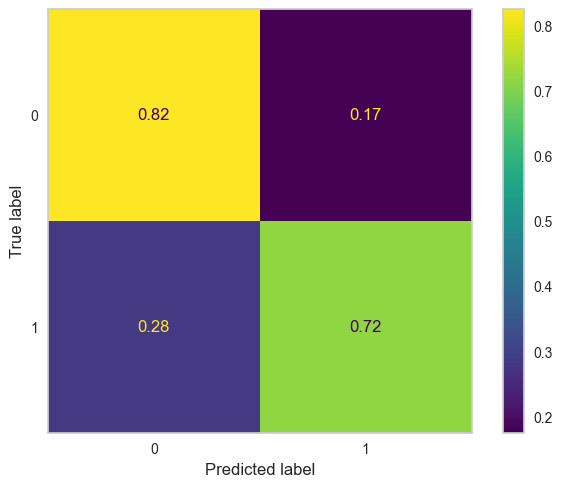

In [46]:
evaluation_plot(MLP, x_test, y_test, y_pred_MLP)

### ROC Curve Analysis for Classification Models

              classifiers                                                fpr  \
0     Logistic Regression  [0.0, 0.0, 0.0, 0.025, 0.025, 0.04166666666666...   
1           Decision Tree  [0.0, 0.008333333333333333, 0.0333333333333333...   
2  Support Vector Machine  [0.0, 0.0, 0.0, 0.016666666666666666, 0.016666...   
3                AdaBoost  [0.0, 0.0, 0.0, 0.008333333333333333, 0.008333...   
4           Random Forest  [0.0, 0.0, 0.0, 0.008333333333333333, 0.008333...   
5              Extra Tree  [0.0, 0.008333333333333333, 0.0083333333333333...   
6                 XGBoost  [0.0, 0.0, 0.0, 0.008333333333333333, 0.008333...   
7                LightGBM  [0.0, 0.0, 0.0, 0.041666666666666664, 0.041666...   
8  Multi-layer Perceptron  [0.0, 0.0, 0.0, 0.008333333333333333, 0.008333...   

                                                 tpr       auc  
0  [0.0, 0.016666666666666666, 0.2, 0.2, 0.216666...  0.831528  
1  [0.0, 0.05, 0.06666666666666667, 0.08333333333...  0.764375  
2  [

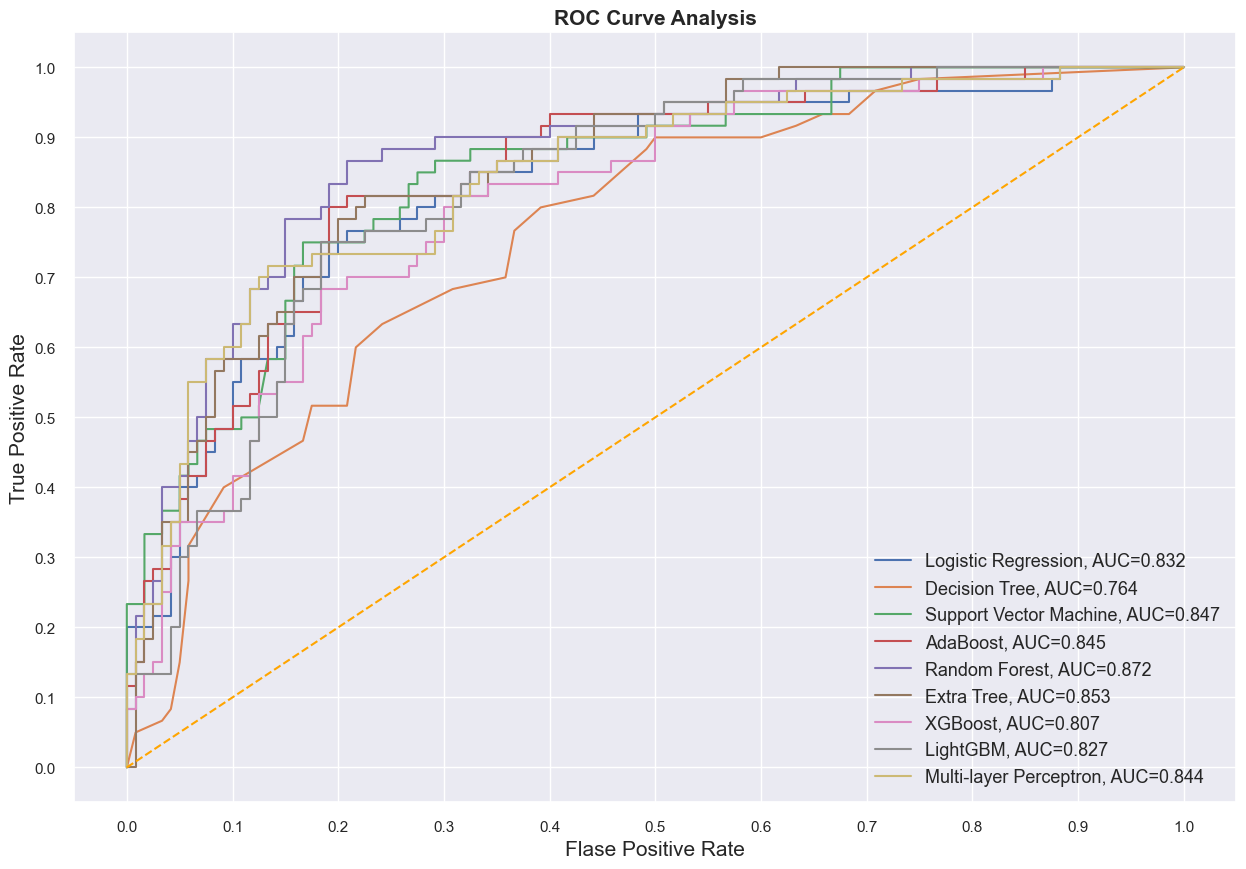

In [47]:
models_auc = []
models_probs = []
classifiers = [LR, DT, svm, AB, RF, ET, XGB, LGBM, MLP]
model_name = ['Logistic Regression', 'Decision Tree', 'Support Vector Machine',
             'AdaBoost', 'Random Forest', 'Extra Tree','XGBoost','LightGBM','Multi-layer Perceptron']
y_preds = [y_pred_LR, y_pred_DT, y_pred_SVM,
         y_pred_AB, y_pred_RF, y_pred_ET,
         y_pred_XGB, y_pred_LGBM, y_pred_MLP]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for y_pred,model in zip(y_preds,classifiers):
  yproba = model.predict_proba(x_test)[:,1]
  models_probs.append(y_pred)
  random_probs = [0 for i in range(len(y_test))]
  p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
  fpr, tpr, threshold = roc_curve(y_test, yproba, pos_label=1)
  auc = roc_auc_score(y_test, yproba)
  models_auc.append(auc)
  result_table = result_table.append({'classifiers':model_name[classifiers.index(model)],
                                      'fpr':fpr,
                                      'tpr':tpr,
                                      'auc':auc}, ignore_index=True)


print(result_table) 
models_auc = pd.DataFrame(models_auc, index=model_name)
models_probs = pd.DataFrame(models_probs, index=model_name).T
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(15,10))
sns.set_theme(style="darkgrid")

for i in result_table.index:
   plt.plot(result_table.loc[i]['fpr'], 
            result_table.loc[i]['tpr'],
            label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))


plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()
    


### Evaluation Metrics Comparison for Classification Models

In [48]:

model_names = ['Logistic Regression', 'Decision Tree Classifier',
               'Support Vector Machine','AdaBoost', 'Random Forest',
               'Extra Tree Classifier', 'XGBoost','LightGBM',
               'Multi-Layer Perceptron']

measurements = [LR_measurement,DT_measurement,
                SVM_measurement,AB_measurement,
                RF_measurement,ET_measurement,
                XGB_measurement,LGBM_measurement,
                MLP_measurement]

eval_met = []

# Populate eval_met list with measurement dictionaries
for model_name, measurement in zip(model_names, measurements):
    eval_dict = {
        'Model': model_name,
        'Accuracy': measurement[0],
        'Precision': measurement[1],
        'Recall': measurement[2],
        'F1': measurement[3],
        'Chen kappa': measurement[4]
    }
    eval_met.append(eval_dict)

# Convert eval_met list of dictionaries into a DataFrame
eval_met = pd.DataFrame(eval_met)

print(tabulate(eval_met, headers= 'keys', tablefmt='fancy_grid'))

╒════╤══════════════════════════╤════════════╤═════════════╤══════════╤════════╤══════════════╕
│    │ Model                    │   Accuracy │   Precision │   Recall │     F1 │   Chen kappa │
╞════╪══════════════════════════╪════════════╪═════════════╪══════════╪════════╪══════════════╡
│  0 │ Logistic Regression      │     0.7833 │      0.678  │   0.6667 │ 0.6723 │       0.5105 │
├────┼──────────────────────────┼────────────┼─────────────┼──────────┼────────┼──────────────┤
│  1 │ Decision Tree Classifier │     0.7222 │      0.5962 │   0.5167 │ 0.5536 │       0.3534 │
├────┼──────────────────────────┼────────────┼─────────────┼──────────┼────────┼──────────────┤
│  2 │ Support Vector Machine   │     0.7667 │      0.6731 │   0.5833 │ 0.625  │       0.4569 │
├────┼──────────────────────────┼────────────┼─────────────┼──────────┼────────┼──────────────┤
│  3 │ AdaBoost                 │     0.7722 │      0.6667 │   0.6333 │ 0.6496 │       0.481  │
├────┼──────────────────────────┼───────